# BLOB AND SIFT FEATURES

In [1]:
import numpy as np 
import cv2 
import pandas as pd 
import skimage.io
import skimage.color
import sys
import os 
import matplotlib.pyplot as plt

In [2]:
sys.path.insert(1, '../')
import sfunc as sf

In [3]:
im = skimage.io.imread('sunflowers.jpg').astype(float)
imb = skimage.color.rgb2gray(im)
type(imb)

numpy.ndarray

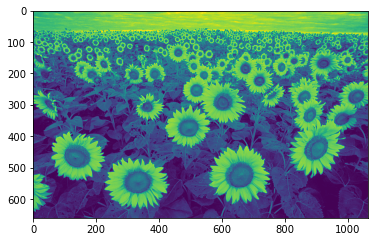

In [4]:
plt.imshow(imb)

In [5]:
def gaussian1DKernel(sigma:int, scale:int=5 ):
    """
    sigma: stadard deviation of the gaussian distribution.
    scale: Range of x times the stadard deviatiion for the x values where we'll evaluate the gaussian.    
    Scale fixed to 5, following the rule of 3std = 99.7% of the data. We make sure we have at least that much.
    
    g: Gaussian distribution given a variance. Column Vector -> (n,1)
        
    If instead of doing it 1D we were doing 2D Kerels, would be much more computational expensive
    from run time O(2*n) --> O(n^2)
    """
    # Width of the Gaussian
    h = np.ceil(scale*sigma)
    x = np.arange(-h, h+1)
    
    # Cte of the Gaussian
    c = (1)/(np.sqrt(2*np.pi)*sigma)
    c_exp = np.exp((-x**2)/(2*sigma**2))
    
    # Gaussian equation 
    g = c*c_exp
    
    return g.reshape(-1,1)

In [6]:
def scaleSpace(im, sigma:int, n:int, retScales:bool=False):
    """
    Apply a Gaussian Kernel of width:
         sigma*2^i; 
    where:
         i = 0, 1, ..., n-1
    
    PARAMETERS 
    im -> image
    sigma -> variance of the gauusian kernel
    n -> range of the width of sigma.
    retScales -> Returns the Scales used if True  
    RETURNS
    im_scales-> pyramid of scales 
    """
    
    width = sigma*2**np.arange(n)
    im_scales = np.zeros((*im.shape, n))
    
    for i, scale in enumerate(width):
        g = gaussian1DKernel(scale)
        im_scales[:,:,i] = cv2.filter2D(cv2.filter2D(im, -1, g), -1, g.T)
    
    if retScales:
        return im_scales, width
    else:
        return im_scales

In [7]:
I = scaleSpace(imb, 1.6, 7)

def plotM_I(I):
    
    n = I.shape[-1]
    n1 = int(np.ceil(np.sqrt(n)))
    n2 = int(np.ceil(n/n1))
    c = 0 

    fig, ax = plt.subplots(n1,n2, figsize=(20,20))
    ax[0][0].imshow(imb)

    for i in range(n1):
        for j in range(n2):
            ax[i][j].imshow(I[:,:,c], cmap='gray')
            c += 1
            if c >= n:
                break

In [8]:
I, s = scaleSpace(imb, 1.6, 7, True)
s

array([  1.6,   3.2,   6.4,  12.8,  25.6,  51.2, 102.4])

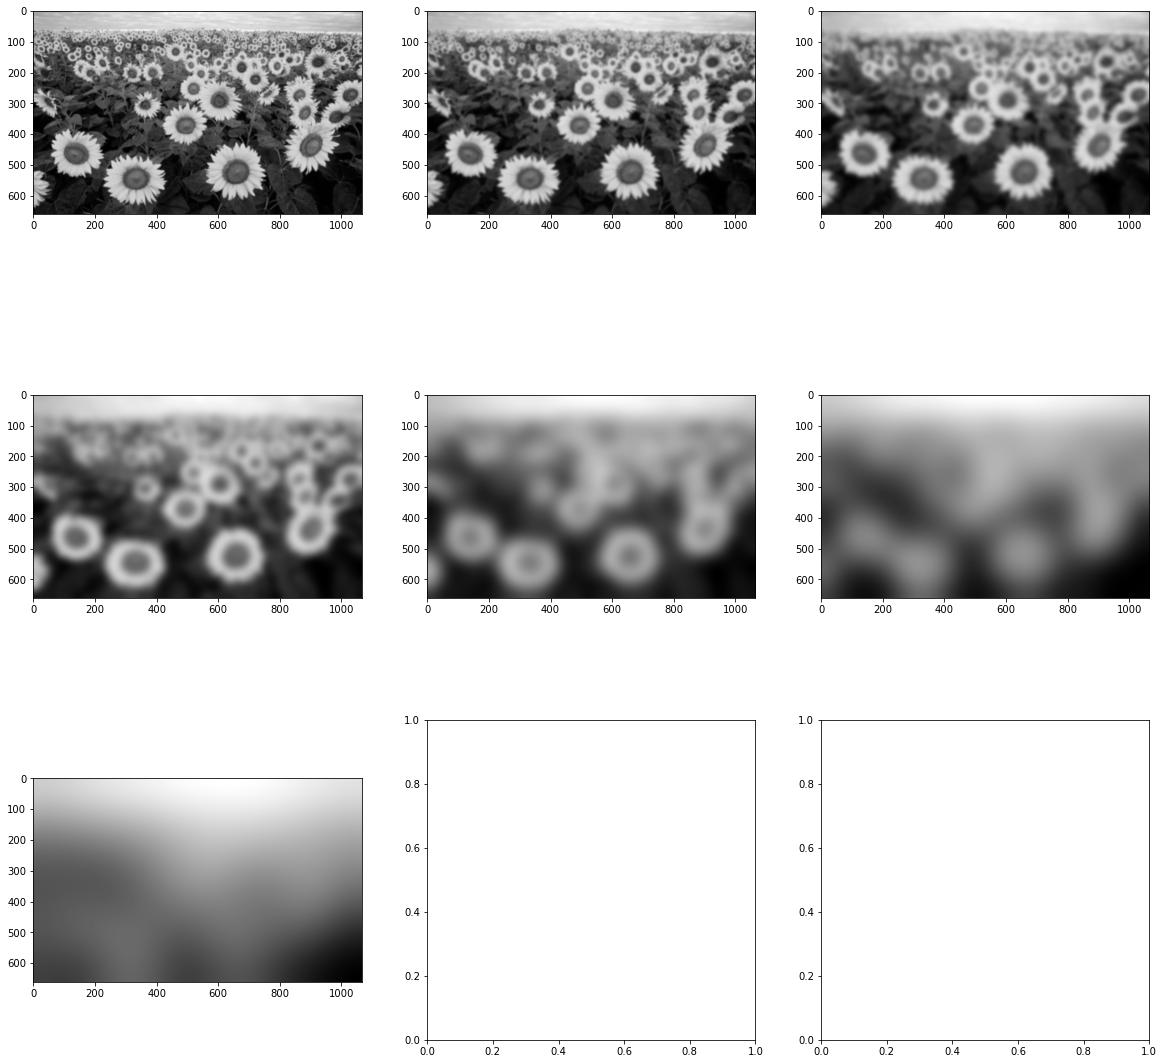

In [9]:
plotM_I(I)

In [14]:
def differenceOfGaussian(im, sigma, n):
    """
    Calculates the differences of smothed images (or images convolved with different Gaussians)
    
    PARAMETERS
    im-> Image 
    sigma-> Variance for tha Gaussian filter 
    n-> max width of gauusian 
    Check scaleSpace function
    
    RETURNS
    DoG -> Differences of gaussians
    
    """

    I = scaleSpace(im, sigma, n)
    
    I_l = I[:,:,1:]
    I_r = I[:,:,:-1]
    
    DoG = I_l - I_r    
    
    return np.abs(DoG)

In [15]:
I_dog = differenceOfGaussian(imb, 1.6, 7)

In [16]:
I_dog.shape

(660, 1066, 6)

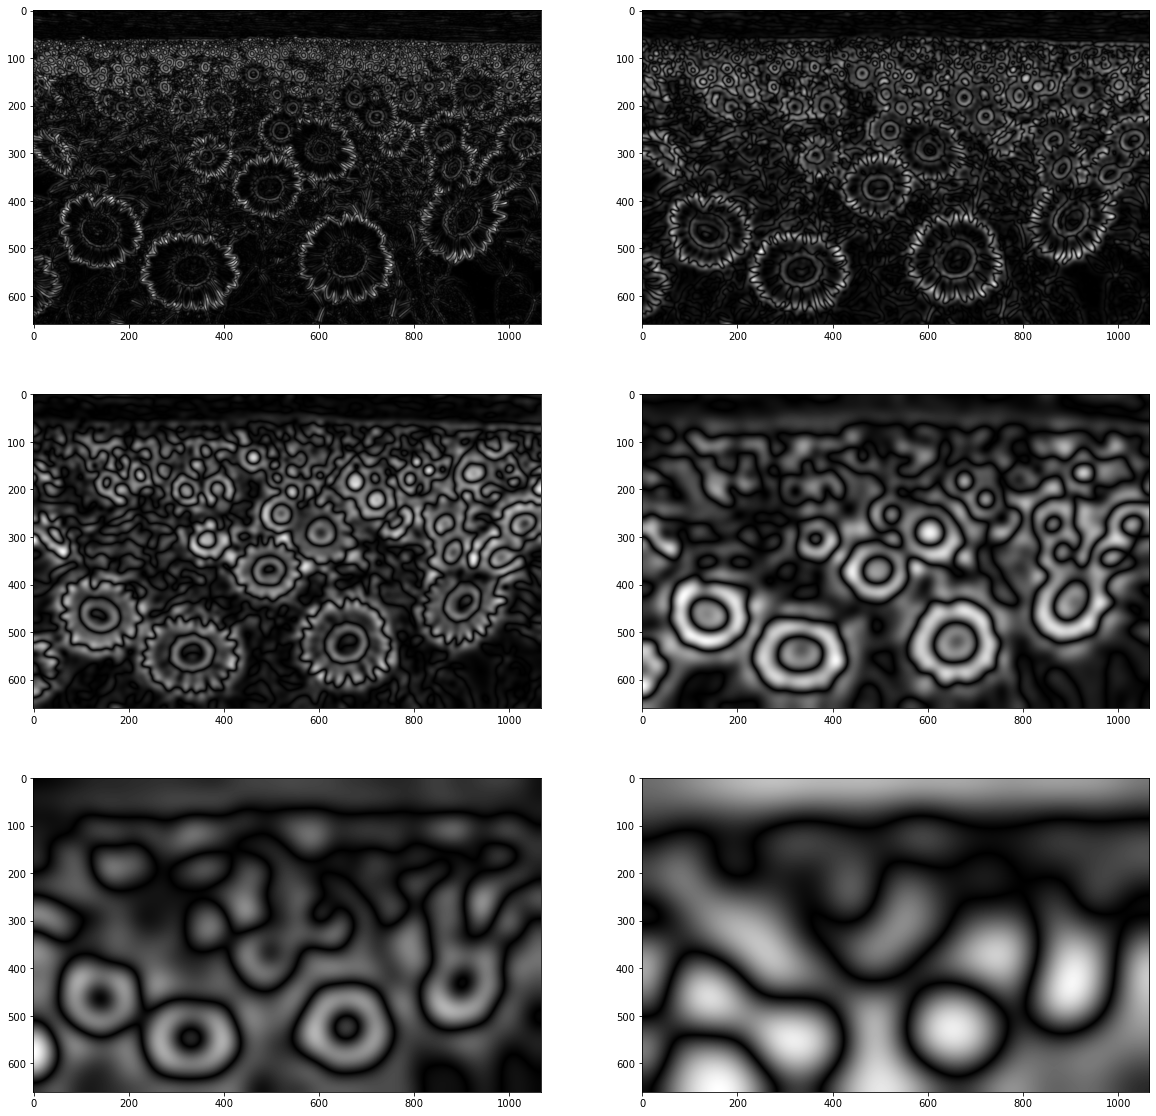

In [17]:
plotM_I(I_dog)

# Non Maximum Supression for 1 Image

In [18]:
def nonMaxsupression4neig_1Image(I, boundaries:bool=False, eight:bool=False):
    """ 
    Apply Non maximum suppresion.
        (I(x, y) − I(x′, y′)) > 0 ∀ x′ ∈ N(x, y) 
    Where N(x, y) is a 4 neighbourhood around the point (x, y)
        (I(x, y) − I(x′, y′)) > 0 = (I(x, y) > I(x′, y′)
    """
    col,row = I.shape
    
    # Create false columns and row for the 
    falsy_r = [boundaries]*col
    falsy_c = [boundaries]*row
    
    # Remember (columns x rows)
    # Upper neighbour
    # r(x, y) > r(x, y + 1)
    Up = I[:-1,:] > I[1:,:]
    Up = np.vstack([Up, falsy_c])
    
    # Lower neighbour 
    # r(x, y) ≥ r(x, y − 1) 
    Low = I[1:,:] >= I[:-1,:] 
    Low = np.vstack([falsy_c, Low])
    
    # Right Neigbhour
    # r(x, y) > r(x + 1, y)
    Right = I[:,:-1] > I[:,1:]
    Right = np.column_stack([Right, falsy_r])
    
    # Left Neighbour 
    # r(x, y) ≥ r(x − 1, y)
    Left = I[:,1:] >= I[:,:-1]
    Left = np.column_stack([falsy_r, Left])
    
    # Find index where all conditions are True
    idx = np.where(Left & Right & Up & Low)
    # Create an empty image 
    I_tmp = np.zeros((col,row))
    # Map the values that fulfill the condition on the empty matrix
    I_tmp[idx] = I[idx]  
    
    if eight:
        # We want to use it in 8 neighbouts, return an array of Ture where condition is fullfiled
        return I_tmp != 0 
    else:
        return I_tmp

In [19]:
def nonMaxsupression8neig_1Image(I, boundaries:bool=False, boolean:bool=False):
    """
    Apply Non maximum suppresion.
        (I(x, y) − I(x′, y′)) > 0 ∀ x′ ∈ N(x, y) 
    Where N(x, y) is a 8 neighbourhood around the point (x, y)
        (I(x, y) − I(x′, y′)) > 0 = (I(x, y) > I(x′, y′)
    """
    
    col,row = I.shape
    
    # Create false columns and row for the 
    falsy_r = [boundaries]*col
    falsy_c = [boundaries]*row
    
       
    # Comparing Top left Corner
    TL = I[1:,1:] > I[:-1,:-1]
    TL_f = np.zeros(I.shape)
    TL_f[0,:] = falsy_c
    TL_f[:,0] = falsy_r
    TL_f[1:,1:] =  TL 
    TL_f = TL_f == 1
    
    # Comparing Top right Corner 
    TR = I[1:,:-1] > I[:-1,1:]
    TR_f = np.zeros(I.shape)
    TR_f[0,:] = falsy_c
    TR_f[:,-1] = falsy_r
    TR_f[1:,:-1] = TR
    TR_f = TR_f == 1
    
    # Comparing Bottom Right Corner
    BR = I[:-1,:-1] > I[1:,1:] 
    BR_f = np.zeros(I.shape)
    BR_f[-1,:] = falsy_c
    BR_f[:,-1] = falsy_r    
    BR_f[:-1,:-1] = BR
    BR_f = BR_f == 1
    
    # Comparing Bottom Left Corner 
    BL = I[:-1,1:] > I[1:,:-1]
    BL_f = np.zeros(I.shape)
    BL_f[-1,:] = falsy_c
    BL_f[:,0] = falsy_r
    BL_f[:-1,1:] = BL
    BL_f = BL_f == 1
    
    # Find index where conditions are fulfilled 
    idx_corners = np.where(TL_f & TR_f & BL_f & BR_f)
    # Create en empty ndarray    
    corners = np.zeros(I.shape)
    corners[idx_corners] = 1
    corners = corners == 1
    
    neig4 = nonMaxsupression4neig_1Image(I, eight=True)
    
    idx_8 = np.where(corners & neig4)
    
    neig8 = np.zeros(I.shape)
    neig8[idx_8] = I[idx_8]
    
    if boolean:
        return neig8 != 0 
    else:
        return neig8

# Non Maximum Supression on Image Vector 
Apply Non Maximum supresion with 4 or 8 neighbour in a 3d vector of images with dimensions (row, columns, d).
Being d the number of images. 
It applies Non maximum supression in each image without foor loops.

In [20]:
def nonMaxsupression4neig(I, boundaries:bool=False, eight:bool=False):
    """ 
    Apply Non maximum suppresion.
        (I(x, y) − I(x′, y′)) > 0 ∀ x′ ∈ N(x, y) 
    Where N(x, y) is a 4 neighbourhood around the point (x, y)
        (I(x, y) − I(x′, y′)) > 0 = (I(x, y) > I(x′, y′)
    """
    col,row, d = I.shape
    
    # Create false columns and row for the columns and rows supressed 
    if boundaries:
        falsy_r = np.ones((col,d))
        falsy_c = np.ones((row,d))        
    else:
        falsy_r = np.zeros((col,d))
        falsy_c = np.zeros((row,d))
        
    # ToDo: Change var names, they are confusinf, falsy_c should be a column vector
    # ToDo: optimize, code, when not using boundaries, it could be fatser not casting the falsy columns and rows 
    
    TR = I[1:,:-1,:] > I[:-1,1:,:]
    TR_f = np.zeros(I.shape)
    TR_f[0,:,:] = falsy_c
    TR_f[:,-1,:] = falsy_r
    TR_f[1:,:-1,:] = TR
    TR_f = TR_f == 1
    
    # Remember (columns x rows)
    # Upper neighbour
    # r(x, y) > r(x, y + 1)
    Up = I[:-1,:,:] > I[1:,:,:]
    Up_f = np.zeros(I.shape)
    Up_f[-1,:,:] = falsy_c
    Up_f[:-1,:,:] = Up
    Up_f = Up_f == 1
    
    # Lower neighbour 
    # r(x, y) ≥ r(x, y − 1) 
    Low = I[1:,:,:] >= I[:-1,:,:] 
    Low_f = np.zeros(I.shape)
    Low_f[0,:,:] = falsy_c
    Low_f[1:,:,:] = Low
    Low_f = Low_f == 1 
    
    # Right Neigbhour
    # r(x, y) > r(x + 1, y)
    Right = I[:,:-1,:] > I[:,1:,:]
    Right_f = np.zeros(I.shape)
    Right_f[:,-1,:] = falsy_r
    Right_f[:,:-1,:] = Right 
    Right_f = Right_f == 1 
    
    # Left Neighbour 
    # r(x, y) ≥ r(x − 1, y)
    Left = I[:,1:,:] >= I[:,:-1,:]
    Left_f = np.zeros(I.shape)
    Left_f[:,0,:] = falsy_r
    Left_f[:,1:,:] = Left
    Left_f = Left_f == 1
        
    # Find index where all conditions are True
    idx = np.where(Left_f & Right_f & Up_f & Low_f)
    # Create an empty image 
    I_tmp = np.zeros(I.shape)
    # Map the values that fulfill the condition on the empty matrix
    I_tmp[idx] = I[idx]
    
    if eight:
        # We want to use it in 8 neighbouts, return an array of Ture where condition is fullfiled
        return I_tmp != 0 
    else:
        return I_tmp

In [21]:
def nonMaxsupression8neig(I, boundaries:bool=False, boolean:bool=False):
    """
    Apply Non maximum suppresion.
        (I(x, y) − I(x′, y′)) > 0 ∀ x′ ∈ N(x, y) 
    Where N(x, y) is a 8 neighbourhood around the point (x, y)
        (I(x, y) − I(x′, y′)) > 0 = (I(x, y) > I(x′, y′)
    """
    
    # Not sure if we'll pass it with d dimensions 
    col,row, d = I.shape
    
    # Create false columns and row for the columns you erase 
    if boundaries:
        falsy_r = np.ones((col,d))
        falsy_c = np.ones((row,d))
    else:
        falsy_r = np.zeros((col,d))
        falsy_c = np.zeros((row,d))
    
       
    # Comparing Top left Corner
    TL = I[1:,1:,:] > I[:-1,:-1,:]
    TL_f = np.zeros(I.shape)
    TL_f[0,:,:] = falsy_c
    TL_f[:,0,:] = falsy_r
    TL_f[1:,1:,:] =  TL 
    TL_f = TL_f == 1
    
    # Comparing Top right Corner 
    TR = I[1:,:-1,:] > I[:-1,1:,:]
    TR_f = np.zeros(I.shape)
    TR_f[0,:,:] = falsy_c
    TR_f[:,-1,:] = falsy_r
    TR_f[1:,:-1,:] = TR
    TR_f = TR_f == 1
    
    # Comparing Bottom Right Corner
    BR = I[:-1,:-1,:] > I[1:,1:,:] 
    BR_f = np.zeros(I.shape)
    BR_f[-1,:,:] = falsy_c
    BR_f[:,-1,:] = falsy_r    
    BR_f[:-1,:-1,:] = BR
    BR_f = BR_f == 1
    
    # Comparing Bottom Left Corner 
    BL = I[:-1,1:,:] > I[1:,:-1,:]
    BL_f = np.zeros(I.shape)
    BL_f[-1,:,:] = falsy_c
    BL_f[:,0,:] = falsy_r
    BL_f[:-1,1:,:] = BL
    BL_f = BL_f == 1
    
    # Find index where conditions are fulfilled 
    idx_corners = np.where(TL_f & TR_f & BL_f & BR_f)
    # Create en empty ndarray    
    corners = np.zeros(I.shape)
    corners[idx_corners] = 1
    corners = corners == 1
    
    neig4 = nonMaxsupression4neig(I, eight=True)
    
    idx_8 = np.where(corners & neig4)
    
    neig8 = np.zeros(I.shape)
    neig8[idx_8] = I[idx_8]
    if boolean:
        return neig8 != 0 
    else:
        return neig8

In [22]:
I2 = nonMaxsupression8neig(I_dog, boolean=True)

# NonMaximumSupression on Extrema Localization

Apply Non maximum supression on a 2 diferent Images. 
Compares the pixels on Image L with the 9 neighbours on Image L+1 

In [23]:
def nonMaxsupression4neig_multilayer(Ilayer, Iabow, boundaries:bool=False, eight:bool=False):
    """ 
    Apply Non maximum suppresion.
        (I(x, y) − I(x′, y′)) > 0 ∀ x′ ∈ N(x, y) 
    Where N(x, y) is a 4 neighbourhood around the point (x, y)
        (I(x, y) − I(x′, y′)) > 0 = (I(x, y) > I(x′, y′)
    
    Ilayer: Image we want to compare
    Iabow: I in layer above or below
    boundaries: False to detect peaks in boundaries False for not detecting 
    eight: True returns a boolean array, False returns the values that are peaks iin 4 nieghbour
    """
    
    # Check Images have the same dimension:
    if Ilayer.shape != Iabow.shape:
        print('Images introduced do not have the same dimensions')
        return False
    
    # Get the dimensions of the image 
    col,row = Ilayer.shape
    
    # Create false columns and rows so we can recreate thw image shape
    falsy_r = [boundaries]*col
    falsy_c = [boundaries]*row
    
    # Check if the pixel in layer l is higher than the pixel in layer l ± 1
    # ToDo: Greater or equal or greater?
    Itslef = Ilayer >= Iabow
    
    # Check if the pixel in layer l is higher than the Right Neigbhour pixel in layer l ± 1
    # rl(x, y) > rl±1(x + 1, y)
    Right = Ilayer[:,:-1] > Iabow[:,1:]
    Right = np.column_stack([Right, falsy_r])
    
    # Check if the pixel in layer l is higher than the Left Neigbhour pixel in layer l ± 1
    # rl(x, y) ≥ rl±1(x − 1, y)
    Left = Ilayer[:,1:] >= Iabow[:,:-1]
    Left = np.column_stack([falsy_r, Left])
    
    # Check if the pixel in layer l is higher than the Upper Neigbhour pixel in layer l ± 1
    # rl(x, y) > rl±1(x, y + 1)
    Up = Ilayer[:-1,:] > Iabow[1:,:]
    Up = np.vstack([Up, falsy_c])
    
    # Check if the pixel in layer l is higher than the Lower Neigbhour pixel in layer l ± 1
    # rl(x, y) ≥ rl±1(x, y − 1) 
    Low = Ilayer[1:,:] >= Iabow[:-1,:] 
    Low = np.vstack([falsy_c, Low])
        
    # Find index where all conditions are True
    idx = np.where(Itslef & Left & Right & Up & Low)
    # Create an empty image 
    I_tmp = np.zeros((col,row))
     # Map the values that fulfill the condition on the empty matrix
    I_tmp[idx] = Ilayer[idx]
    
    if eight:
        # We want to use it in 8 neighbouts, return an array of Ture where condition is fullfiled
        return I_tmp != 0
    else:
        return I_tmp

In [24]:
def nonMaxsupression8neig_multilayer(Ilayer, Iabow, boundaries:bool=False, boolean: bool=False):
    """
    Apply Non maximum suppresion.
        (I(x, y) − I(x′, y′)) > 0 ∀ x′ ∈ N(x, y) 
    Where N(x, y) is a 8 neighbourhood around the point (x, y)
        (I(x, y) − I(x′, y′)) > 0 = (I(x, y) > I(x′, y′)
    
    Ilayer: Image we want to compare
    Iabow: I in layer above or below
    boundaries: False to detect peaks in boundaries False for not detecting 
    boolean: Return a Boolean Array if True and the numbers of the peaks if False. 
    
    """
    
    # Call 4 neighbour so we make checkings.
    neig4 = nonMaxsupression4neig_multilayer(Ilayer, Iabow, eight=True)
    
    shape = Ilayer.shape
    col,row = shape
    
    # Create false columns and row for the 
    falsy_r = [boundaries]*col
    falsy_c = [boundaries]*row
    
    
    # Check if the pixel in layer l is higher than the Top Left Corner Neigbhour pixel in layer l ± 1
    # rl(x, y) > rl±1(x-1, y-1)
    TL = Ilayer[1:,1:] > Iabow[:-1,:-1]
    TL_f = np.zeros(shape)
    TL_f[0,:] = falsy_c
    TL_f[:,0] = falsy_r
    TL_f[1:,1:] =  TL 
    TL_f = TL_f == 1
    
    # Check if the pixel in layer l is higher than the Top Right Corner Neigbhour pixel in layer l ± 1
    # rl(x, y) > rl±1(x-1, y+1)
    TR = Ilayer[1:,:-1] >= Iabow[:-1,1:]
    TR_f = np.zeros(shape)
    TR_f[0,:] = falsy_c
    TR_f[:,-1] = falsy_r
    TR_f[1:,:-1] = TR
    TR_f = TR_f == 1
    
    # Check if the pixel in layer l is higher than the Bottom Right Corner Neigbhour pixel in layer l ± 1
    # rl(x, y) > rl±1(x+1, y+1)
    BR = Ilayer[:-1,:-1] >= Iabow[1:,1:] 
    BR_f = np.zeros(shape)
    BR_f[-1,:] = falsy_c
    BR_f[:,-1] = falsy_r    
    BR_f[:-1,:-1] = BR
    BR_f = BR_f == 1
    
    # Check if the pixel in layer l is higher than the Bottom Left Corner Neigbhour pixel in layer l ± 1
    # rl(x, y) > rl±1(x+1, y-1)
    BL = Ilayer[:-1,1:] > Iabow[1:,:-1]
    BL_f = np.zeros(shape)
    BL_f[-1,:] = falsy_c
    BL_f[:,0] = falsy_r
    BL_f[:-1,1:] = BL
    BL_f = BL_f == 1
    
    # Find index where conditions are fulfilled 
    idx_corners = np.where(TL_f & TR_f & BL_f & BR_f)
    # Create en empty ndarray of shape Image    
    corners = np.zeros(shape)
    corners[idx_corners] = 1
    corners = corners == 1
    
    idx_8 = np.where(corners & neig4)
    
    neig8 = np.zeros(shape)
    neig8[idx_8] = Ilayer[idx_8]
    
    if boolean:
        return neig8 != 0 
    else:
        return neig8

# Non Maximum Supression Multi Layer
Apply Non Mximum Supression on a vector of images, checking for peaks on the image itself, on the image on the above layer and the image on the layer below

## Function to create a circle in a desired coordinate

In [25]:
def circles(x, y, r:int=5, points:int=100):
    """
    Cretes the coordinates of a circle of a given radius and a specific center.
    
    
    PARAMETERS
    x -> x coordinate of the center of the circle, can be integer or array (n,)
         Can be index found with np.where 
    y -> y coordinate of the center of the circle, can be integer or array (n,)
         Can be index found with np.where 
    
    RETURNS
    Cx -> X coordinates of the circle (points, n)
    Cy -> Y coordinates of the circle (points, n)
    Beinng 
    """
    
    c_range = np.linspace(0, 2*np.pi, points).reshape(-1,1)

    if type(x) == int:
        print('integer')
        Cx = np.squeeze(np.array([x + r*np.cos(c_range)])).reshape(-1,1)
        Cy = np.squeeze(np.array([y + r*np.sin(c_range)])).reshape(-1,1)
    
    else:
        x = np.array(x)
        y = np.array(y)
        # Reshape arrays into desired dimensions
        x = sf.squeezdim(x).reshape(1, -1)
        y = sf.squeezdim(y).reshape(1, -1)
        
        Cx = np.squeeze(np.array([x + r*np.cos(c_range)]))
        Cy = np.squeeze(np.array([y + r*np.sin(c_range)]))
        
        try: 
            m,n = Cx.shape
            pass
        except ValueError:
            Cx = Cx.reshape(-1,1)
            Cy = Cy.reshape(-1,1)
    if not Cx.size:
        Cx = c_range*0
        Cy = c_range*0
    return Cx, Cy

In [26]:
a1 = nonMaxsupression8neig_multilayer(I_dog[:,:,0], I_dog[:,:,1], boolean=True)
a2 = nonMaxsupression8neig_1Image(I_dog[:,:,0], boolean=True)
a3 = nonMaxsupression8neig(I_dog, boolean=True)
idx = np.where(a2==a3[:,:,0])

np.where(a1 & a2)

(array([  1,   1,   1, ..., 657, 657, 658], dtype=int64),
 array([ 541,  577,  627, ...,  900, 1032,  587], dtype=int64))

In [27]:
def detectBlobs(im, sigma, n, threshold:float=0.8):
    """
    """
    
    # Obtain the scale used on the gaussians 
    _,scale = scaleSpace(im,sigma,n, retScales=True)
    
    # Calculate the difference of gaussians
    I_dog = differenceOfGaussian(im, sigma, n)
    
    # Get the number of images 
    d = I_dog.shape[-1]
    
    # Create an empty array of dimensions I_dog to stroe the peaks 
    I_peaks = np.zeros(I_dog.shape)
    
    # Compute peaks over images itself fast computation
    I_itself = nonMaxsupression8neig(I_dog, boolean=True)
    
    # Loop over the images abd calculate NonMaximum supresion
    for i in range(d):
        if not i:
            print('Layer: ', i)
            # First Layer, compare only with the next one. 
            above = nonMaxsupression8neig_multilayer(I_dog[:,:,i], I_dog[:,:,i+1], boolean=True)
            itself = I_itself[:,:,i]
            # Find maximum value of the image, to apply threshold
            mx = np.max(I_dog[:,:,i])
            T = I_dog[:,:,i] > (threshold*mx)
            idx = np.where(above & itself & T)
            I_peaks[idx[0], idx[1], i] = I_dog[idx[0], idx[1], i]
            Cx, Cy = circles(idx[0], idx[1], scale[i])
            print(scale[i])
        elif i == d-1:
            print('Layer: ', i)
            # Last layer, compare only with the previuos one 
            below = nonMaxsupression8neig_multilayer(I_dog[:,:,i], I_dog[:,:,i-1], boolean=True)
            itself = I_itself[:,:,i]
            mx = np.max(I_dog[:,:,i])
            T = I_dog[:,:,i] > (threshold*mx)
            idx = np.where(itself & below & T)
            I_peaks[idx[0], idx[1], i] = I_dog[idx[0], idx[1], i]
            Cx_tmp, Cy_tmp = circles(idx[0], idx[1], scale[i])
            Cx = np.concatenate([Cx, Cx_tmp], axis = 1)
            Cy = np.concatenate([Cy, Cy_tmp], axis = 1)
            
        else:
            print('Layer: ', i)
            # Layers inbetween 
            above = nonMaxsupression8neig_multilayer(I_dog[:,:,i], I_dog[:,:,i+1], boolean=True)
            below = nonMaxsupression8neig_multilayer(I_dog[:,:,i], I_dog[:,:,i-1], boolean=True)
            itself = I_itself[:,:,i]
            mx = np.max(I_dog[:,:,i])
            T = I_dog[:,:,i] > (threshold*mx)
            idx = np.where(above & itself & below & T)
            I_peaks[idx[0], idx[1], i] = I_dog[idx[0], idx[1], i]
            Cx_tmp, Cy_tmp = circles(idx[0], idx[1], scale[i])
            Cx = np.concatenate([Cx, Cx_tmp], axis = 1)
            Cy = np.concatenate([Cy, Cy_tmp], axis = 1)
            print(scale[i])
            
        
    return I_peaks, Cx, Cy

In [30]:
I_p, Cx, Cy = detectBlobs(imb, 0.5, 10)

Layer:  0
0.5
Layer:  1
1.0
Layer:  2
2.0
Layer:  3
4.0
Layer:  4
8.0
Layer:  5
16.0
Layer:  6
32.0
Layer:  7
64.0
Layer:  8


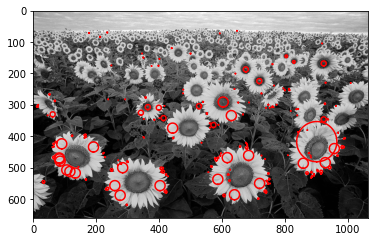

In [31]:
plt.imshow(imb, cmap='gray')
plt.plot(Cy, Cx, 'r')

In [99]:
iidx

NameError: name 'iidx' is not defined

In [107]:
C = np.random.randint(20, size=(5,5))
P = np.random.randint(20, size=(5,5))

In [108]:
print(C)
print('')
print(P)

[[ 9 10 18  5  3]
 [15  4  1  0 16]
 [ 2 16  3 13 18]
 [17 18 19 17  8]
 [ 4 11  6  8 19]]

[[12  2 16  7 15]
 [11 11 17  6 16]
 [11 18 17 16  3]
 [ 8 15  1 14  2]
 [ 7  2  4  5  7]]


In [109]:
lay = nonMaxsupression8neig_multilayer(C, P, boolean=True)
it = nonMaxsupression8neig_1Image(C, boolean= True)
print(lay)
print('')
print(it)
mx = np.max(C)
idx = np.where(lay & it)
Z = np.zeros((5,5))
Z[idx] = C[idx]
print('')
print(Z)
T = C>18
print('')
print(T)
idx2 = np.where(lay & it & (C>18))
Z = np.zeros((5,5))
Z[idx2] = C[idx2]
print(Z)

[[False False False False False]
 [False False False False False]
 [False False False False False]
 [False  True  True False False]
 [False False False False False]]

[[False False False False False]
 [False False False False False]
 [False False False False False]
 [False False  True False False]
 [False False False False False]]

[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0. 19.  0.  0.]
 [ 0.  0.  0.  0.  0.]]

[[False False False False False]
 [False False False False False]
 [False False False False False]
 [False False  True False False]
 [False False False False  True]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0. 19.  0.  0.]
 [ 0.  0.  0.  0.  0.]]


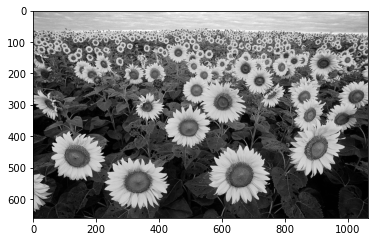

In [110]:
plt.imshow(imb, cmap='gray')

In [126]:
idx = np.where(Z == False)
print(np.append(idx[0], idx[1]))
x = np.array((), dtype=int)
x
x = np.append(x, idx[0])
x

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 4 4 4 4 4 0 1 2 3 4 0 1 2 3 4 0 1 2
 3 4 0 1 3 4 0 1 2 3 4]


array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4,
       4, 4], dtype=int64)

In [102]:
Cx, Cy = circles([], [], 50)


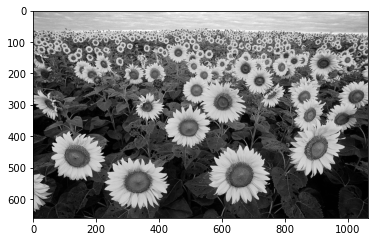

In [103]:
plt.imshow(imb, cmap='gray')
plt.plot(Cx, Cy, 'r')

In [104]:
x = np.linspace(0, 2*np.pi, 360).reshape(-1,1)
a = np.array([50, 100, 150, 200, 250, 350]).reshape(1,-1)
b = np.array([50, 100, 150, 200, 250, 350])

Cy = np.squeeze(np.array([a + r*np.cos(x)]))
x.shape, a.shape, Cy.shape

NameError: name 'r' is not defined

In [105]:
x = np.linspace(0, 2*np.pi, 360).reshape(-1,1)
g = a+x
print(g[:10,:5])

[[ 50.         100.         150.         200.         250.        ]
 [ 50.01750191 100.01750191 150.01750191 200.01750191 250.01750191]
 [ 50.03500382 100.03500382 150.03500382 200.03500382 250.03500382]
 [ 50.05250573 100.05250573 150.05250573 200.05250573 250.05250573]
 [ 50.07000764 100.07000764 150.07000764 200.07000764 250.07000764]
 [ 50.08750954 100.08750954 150.08750954 200.08750954 250.08750954]
 [ 50.10501145 100.10501145 150.10501145 200.10501145 250.10501145]
 [ 50.12251336 100.12251336 150.12251336 200.12251336 250.12251336]
 [ 50.14001527 100.14001527 150.14001527 200.14001527 250.14001527]
 [ 50.15751718 100.15751718 150.15751718 200.15751718 250.15751718]]


In [112]:
x0,y0,r = 600, 300, 30
x1, y1 = 200,100
x = np.linspace(0, 2*np.pi, 360)

Cx = np.array([y0 + r*np.sin(x), y1 + r*np.sin(x)]).T
Cy = np.array([x0 + r*np.cos(x), x1 + r*np.cos(x)]).T
Cx.shape

(360, 2)

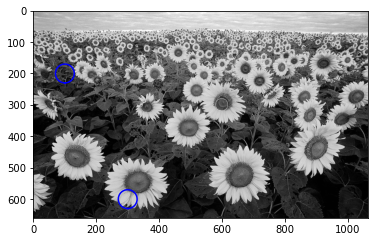

In [113]:
plt.imshow(imb, cmap='gray')
plt.plot(Cx, Cy, 'b')

In [ ]:
    # Loop over the images abd calculate NonMaximum supresion
    for image in range(d):
        if not image:
            print
            # First Layer, compare only with the next one. 
#             above = nonMaxsupression8neig_multilayer(I_dog[:,:,i], I_dog[:,:,i+1], boolean=True)
#             itself = I_itself[:,:,i]
#             # Find maximum value of the image, to apply threshold
#             mx = np.max(I_dog[:,:,i])
#             T = I_dog[:,:,i] > (threshold*mx)
#             idx = np.where(above & itself & T)
#             I_peaks[idx, i] = I_dog[idx, i]
            
        elif image == d-1:
            # Last layer, compare only with the previuos one 
            below = nonMaxsupression8neig_multilayer(I_dog[:,:,i], I_dog[:,:,i-1], boolean=True)
            itself = I_itself[:,:,i]
            mx = np.max(I_dog[:,:,i])
            T = I_dog[:,:,i] > (threshold*mx)
            idx = np.where(itself & below & T)
            I_peaks[idx, i] = I_dog[idx, i]
            
        else:
            # Layers inbetween 
            above = nonMaxsupression8neig_multilayer(I_dog[:,:,i], I_dog[:,:,i+1], boolean=True)
            below = nonMaxsupression8neig_multilayer(I_dog[:,:,i], I_dog[:,:,i-1], boolean=True)
            itself = I_itself[:,:,i]
            mx = np.max(I_dog[:,:,i])
            T = I_dog[:,:,i] > (threshold*mx)
            idx = np.where(above & itself & below & T)
            I_peaks[idx, i] = I_dog[idx, i]

In [30]:
a = [i for i in range(5)]
b = np.array(list(range(5,11)))
b.shape

(6,)

In [31]:
a*2

[0, 1, 2, 3, 4, 0, 1, 2, 3, 4]

In [89]:
V1 = np.array([[18,  2,  8, 19,  2, 18],
 [10,  2, 17, 13, 12,  4],
 [ 2, 18, 15,  8, 19, 15],
 [11,  9,  8,  1,  7, 18],
 [ 0,  5,  6, 14, 14, 12],
 [13, 14, 19, 15, 15,  1]])
V1[1,1] = 20
V1[3,1] = 19
V1[-1,2] = 16
V1[3,3] = 12
V1[4,3] = 17

In [90]:
V2 = np.array([[18,  2,  8, 19,  2, 18],
       [10, 19, 17, 13, 12,  4],
       [ 2, 18, 15,  8, 19, 15],
       [11, 20,  8, 12,  7, 18],
       [ 0,  5,  6, 18, 14, 12],
       [13, 14, 16, 15, 15,  1]])

In [91]:
print(V1)
nonMaxsupression8neig_1Image(V1, boolean=True)

[[18  2  8 19  2 18]
 [10 20 17 13 12  4]
 [ 2 18 15  8 19 15]
 [11 19  8 12  7 18]
 [ 0  5  6 17 14 12]
 [13 14 16 15 15  1]]


array([[False, False, False, False, False, False],
       [False,  True, False, False, False, False],
       [False, False, False, False,  True, False],
       [False,  True, False, False, False, False],
       [False, False, False,  True, False, False],
       [False, False, False, False, False, False]])

In [92]:
print(V1)
print('')
print(V2)


[[18  2  8 19  2 18]
 [10 20 17 13 12  4]
 [ 2 18 15  8 19 15]
 [11 19  8 12  7 18]
 [ 0  5  6 17 14 12]
 [13 14 16 15 15  1]]

[[18  2  8 19  2 18]
 [10 19 17 13 12  4]
 [ 2 18 15  8 19 15]
 [11 20  8 12  7 18]
 [ 0  5  6 18 14 12]
 [13 14 16 15 15  1]]


In [93]:
print(nonMaxsupression8neig_multilayer(V1, V2, boolean=True))


[[False False False False False False]
 [False  True False False False False]
 [False False False False  True False]
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]]


In [74]:
nonMaxsupression8neig_1Image(V2, boolean=True)

array([[False, False, False, False, False, False],
       [False,  True, False, False, False, False],
       [False, False, False, False,  True, False],
       [False,  True, False, False, False, False],
       [False, False, False,  True, False, False],
       [False, False, False, False, False, False]])

In [32]:
A = np.random.randint(20, size=(6, 6, 4))
print(A[:,:,0])
print('')
print(A[:,:,1])
print('')
print(A[:,:,2])
print('')
print(A[:,:,3])

[[18  2  8 19  2 18]
 [10  2 17 13 12  4]
 [ 2 18 15  8 19 15]
 [11  9  8  1  7 18]
 [ 0  5  6 14 14 12]
 [13 14 19 15 15  1]]

[[ 2 12  3 14 13 15]
 [ 9  6  3  2  6 13]
 [ 2  5  3 11 16 17]
 [ 0 17 19 12  5  1]
 [14 17 18  9 14 17]
 [ 8  4  6 16  7 17]]

[[13  4 18  2 14 12]
 [12  4 19 12 12 11]
 [ 3 19 11 14  1 17]
 [ 5  8 16 17  4 19]
 [ 1 17 13  0  6 13]
 [ 3  8  9  9  8  9]]

[[14  7  3  8  1 10]
 [18 13  7  4 17 18]
 [13 18  5  8  3 10]
 [ 8 15  1  1 17  8]
 [10  9 13  4  7 14]
 [ 4  6  6 12  9 16]]


nonmaxsuprssion on a vectrial form is not behaving correctly. <br> 
Check if the non maximum supression on 4 neigbhour is implmented correctly.

In [42]:
G1 = nonMaxsupression8neig(A, boolean=True)
G1[:,:,0]

array([[False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False,  True, False, False,  True, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False]])

In [43]:
G1[:,:,1]

array([[False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False,  True, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False]])

In [44]:
P1 = nonMaxsupression8neig_1Image(A[:,:,0], boolean=True)
P1

array([[False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False,  True, False, False,  True, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False]])

In [45]:
P2 = nonMaxsupression8neig_1Image(A[:,:,1], boolean=True)
P2

array([[False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False,  True, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False]])

In [46]:
P2 == G1[:,:,1]

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])